In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import h5py
from tqdm import tqdm
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import root_scalar

In [3]:
!ls ../Data/Sims/

Astrid	   IllustrisTNG     SIMBA     Swift-EAGLE
Astrid_DM  IllustrisTNG_DM  SIMBA_DM  Swift-EAGLE_DM


# Astrid

In [9]:
simu = 'Astrid'

In [ ]:
isim = 2
box_size = 25 # MPc/h

for isim in range(99):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')
    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 90) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando halo: 0 con 245 galaxias


245it [02:12,  1.85it/s]


Analizando halo: 1 con 263 galaxias


263it [02:23,  1.84it/s]


Analizando halo: 2 con 172 galaxias


172it [01:36,  1.79it/s]


Analizando halo: 3 con 157 galaxias


157it [01:23,  1.88it/s]


Analizando simu 1
Analizando simu 2
Analizando halo: 0 con 413 galaxias


413it [03:23,  2.03it/s]


Analizando halo: 1 con 208 galaxias


208it [01:42,  2.03it/s]


Analizando halo: 2 con 145 galaxias


145it [01:09,  2.10it/s]


Analizando simu 3
Analizando halo: 0 con 407 galaxias


407it [03:06,  2.18it/s]


Analizando halo: 1 con 219 galaxias


219it [01:36,  2.26it/s]


Analizando halo: 2 con 185 galaxias


185it [01:26,  2.14it/s]


Analizando halo: 3 con 236 galaxias


236it [01:41,  2.32it/s]


Analizando simu 4
Analizando halo: 0 con 513 galaxias


513it [04:20,  1.97it/s]


Analizando halo: 1 con 242 galaxias


242it [02:19,  1.73it/s]


Analizando halo: 2 con 140 galaxias


140it [01:21,  1.73it/s]


Analizando simu 5
Analizando halo: 0 con 540 galaxias


540it [04:20,  2.07it/s]


Analizando halo: 1 con 255 galaxias


255it [02:10,  1.95it/s]


Analizando halo: 2 con 306 galaxias


306it [02:16,  2.24it/s]


Analizando halo: 3 con 173 galaxias


173it [01:23,  2.06it/s]


Analizando simu 6
Analizando halo: 0 con 461 galaxias


461it [02:19,  3.31it/s]


Analizando simu 7
Analizando halo: 0 con 610 galaxias


610it [05:23,  1.89it/s]


Analizando halo: 1 con 124 galaxias


124it [01:08,  1.82it/s]


Analizando halo: 2 con 110 galaxias


110it [00:56,  1.95it/s]


Analizando simu 8
Analizando simu 9
Analizando halo: 0 con 240 galaxias


240it [01:19,  3.04it/s]


Analizando simu 10
Analizando halo: 0 con 273 galaxias


273it [01:40,  2.72it/s]


Analizando halo: 1 con 202 galaxias


202it [01:14,  2.72it/s]


Analizando halo: 2 con 141 galaxias


141it [00:49,  2.87it/s]


Analizando simu 11
Analizando simu 12
Analizando halo: 0 con 189 galaxias


189it [00:47,  3.96it/s]


Analizando simu 13
Analizando halo: 0 con 189 galaxias


189it [01:03,  2.97it/s]


Analizando halo: 1 con 212 galaxias


212it [01:06,  3.18it/s]


Analizando halo: 2 con 196 galaxias


196it [01:02,  3.13it/s]


Analizando simu 14
Analizando halo: 0 con 216 galaxias


216it [01:39,  2.16it/s]


Analizando simu 15
Analizando halo: 0 con 206 galaxias


206it [01:15,  2.74it/s]


Analizando simu 16
Analizando simu 17
Analizando halo: 0 con 148 galaxias


148it [00:55,  2.66it/s]


Analizando simu 18
Analizando simu 19
Analizando halo: 0 con 503 galaxias


503it [01:58,  4.23it/s]


Analizando simu 20
Analizando halo: 0 con 203 galaxias


203it [01:23,  2.43it/s]


Analizando halo: 1 con 175 galaxias


175it [01:09,  2.50it/s]


Analizando halo: 2 con 133 galaxias


133it [00:52,  2.53it/s]


Analizando halo: 3 con 156 galaxias


156it [01:05,  2.40it/s]


Analizando simu 21
Analizando halo: 0 con 654 galaxias


654it [06:32,  1.67it/s]


Analizando halo: 1 con 170 galaxias


170it [01:51,  1.53it/s]


Analizando simu 22
Analizando halo: 0 con 388 galaxias


388it [02:57,  2.19it/s]


Analizando halo: 1 con 157 galaxias


157it [01:09,  2.25it/s]


Analizando simu 23
Analizando simu 24
Analizando halo: 0 con 252 galaxias


252it [01:16,  3.31it/s]


Analizando simu 25
Analizando halo: 0 con 218 galaxias


218it [01:06,  3.27it/s]


Analizando halo: 1 con 163 galaxias


163it [00:54,  3.01it/s]


Analizando simu 26
Analizando halo: 0 con 477 galaxias


477it [03:10,  2.50it/s]


Analizando halo: 1 con 335 galaxias


335it [02:10,  2.57it/s]


Analizando halo: 2 con 240 galaxias


240it [01:35,  2.52it/s]


Analizando simu 27
Analizando halo: 0 con 274 galaxias


274it [01:45,  2.61it/s]


Analizando simu 28
Analizando halo: 0 con 263 galaxias


263it [01:19,  3.31it/s]


Analizando simu 29
Analizando simu 30
Analizando halo: 0 con 331 galaxias


331it [01:40,  3.29it/s]


Analizando halo: 1 con 244 galaxias


244it [01:05,  3.72it/s]


Analizando simu 31
Analizando halo: 0 con 300 galaxias


300it [01:54,  2.63it/s]


Analizando halo: 1 con 150 galaxias


150it [00:54,  2.74it/s]


Analizando halo: 2 con 100 galaxias


100it [00:38,  2.57it/s]


Analizando halo: 3 con 125 galaxias


125it [00:44,  2.80it/s]


Analizando simu 32
Analizando halo: 0 con 303 galaxias


303it [02:54,  1.73it/s]


Analizando halo: 1 con 301 galaxias


301it [02:56,  1.71it/s]


Analizando halo: 2 con 277 galaxias


277it [02:34,  1.80it/s]


Analizando halo: 3 con 126 galaxias


126it [01:16,  1.65it/s]


Analizando simu 33
Analizando halo: 0 con 364 galaxias


364it [02:29,  2.44it/s]


Analizando simu 34
Analizando halo: 0 con 798 galaxias


798it [05:27,  2.44it/s]


Analizando halo: 1 con 180 galaxias


180it [01:15,  2.39it/s]


Analizando halo: 2 con 158 galaxias


158it [01:11,  2.22it/s]


Analizando halo: 3 con 128 galaxias


102it [00:46,  3.33it/s]

# TNG

In [89]:
simu = 'IllustrisTNG'
box_size = 25 # MPc/h

In [ ]:
for isim in range(100):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando halo: 0 con 74 galaxias


74it [00:08,  9.14it/s]


Analizando halo: 1 con 83 galaxias


83it [00:07, 10.69it/s]


Analizando simu 1
Analizando halo: 0 con 64 galaxias


64it [00:07,  8.57it/s]


Analizando halo: 1 con 84 galaxias


84it [00:08,  9.59it/s]


Analizando simu 2
Analizando halo: 0 con 312 galaxias


312it [00:33,  9.29it/s]


Analizando halo: 1 con 111 galaxias


111it [00:12,  9.16it/s]


Analizando simu 3
Analizando simu 4
Analizando halo: 0 con 120 galaxias


120it [00:08, 14.51it/s]


Analizando simu 5
Analizando halo: 0 con 34 galaxias


34it [00:04,  7.87it/s]


Analizando simu 6
Analizando halo: 0 con 84 galaxias


84it [00:10,  8.07it/s]


Analizando halo: 1 con 97 galaxias


97it [00:09, 10.40it/s]


Analizando halo: 2 con 81 galaxias


81it [00:07, 10.70it/s]


Analizando simu 7
Analizando halo: 0 con 165 galaxias


165it [00:18,  8.92it/s]


Analizando halo: 1 con 74 galaxias


74it [00:07,  9.39it/s]


Analizando halo: 2 con 57 galaxias


57it [00:06,  9.50it/s]


Analizando halo: 3 con 57 galaxias


57it [00:05,  9.90it/s]


Analizando halo: 4 con 61 galaxias


61it [00:06, 10.03it/s]


Analizando halo: 5 con 32 galaxias


32it [00:03,  9.50it/s]


Analizando simu 8
Analizando halo: 0 con 330 galaxias


330it [00:36,  9.02it/s]


Analizando halo: 1 con 344 galaxias


172it [00:21,  7.59it/s]

# SIMBA

In [66]:
simu = 'SIMBA'
box_size = 25 # MPc/h

In [77]:
for isim in range(2):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando simu 1
Analizando halo: 0 con 230 galaxias


230it [00:22, 10.33it/s]


# Swift-EAGLE (NO HAY sublink_gal)

In [87]:
simu = 'Swift-EAGLE'
box_size = 25 # MPc/h

In [88]:
for isim in range(2):
    print('Analizando simu ' + str(isim))
    # Busquemos los halos
    f_catalog  = '../Data/FOF_Subfind/' + simu + '/L25n256/LH/LH_' + str(isim) + '/groups_090.hdf5'
    f = h5py.File(f_catalog, 'r')

    # Seleccionemos los grupos con masas mayores a 1e13.5
    halo_ind = np.where(np.log10(f['Group/GroupMass'][()] * 1e10) > 13.5)[0]

    if len(halo_ind) > 0:
        # Seleccionemos las galaxias que pertenecen a cada halo
        gal_ind = np.where(f['Subhalo/SubhaloGrNr'][()] == halo_ind[0])[0]
    
        # Chequiamos que esten todas las galaxias
        f['Group/GroupNsubs'][()][halo_ind[0]] == len(gal_ind)
    
        # Buscamos el parent
        sublink = h5py.File('../Data/SubLink_gal/' + simu + '/L25n256/LH/LH_' + str(isim) + '/tree_extended.hdf5', 'r')    
    
        halo_properties = {}
        for haloIndice in halo_ind:
            halo_properties['haloID:' + str(haloIndice)] = {}
            
            # Indices de las galaxias pertenecientes a un halo a un dado snapshot
            gal_indices = np.where((sublink['SnapNum'][()] == 33) & (sublink['SubhaloGrNr'][()] == haloIndice))[0]
            
            # Primero busquemos la posicion y velocidad del grupo
            FirstSubhaloInFOFGroupID = sublink['FirstSubhaloInFOFGroupID'][gal_indices][0]
            indice = np.where(sublink['SubhaloID'] == FirstSubhaloInFOFGroupID)[0][0]
            FirstProgID = sublink['FirstProgenitorID'][indice]
                
            mainHalo_dict = {}
            groupID = []
            pos = []
            vel = []
            while FirstProgID > 0:
                groupID = sublink['SubhaloGrNr'][indice]
                snap = sublink['SnapNum'][indice]
                
                halo_pos = sublink['GroupPos'][indice] / 1e3 # Mpc/h
                halo_vel = sublink['GroupVel'][indice] # km/s
                
                indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                mainHalo_dict['snap:' + str(snap)] = {}
                mainHalo_dict['snap:' + str(snap)]['groupID'] = groupID
                mainHalo_dict['snap:' + str(snap)]['pos'] = np.array(halo_pos)
                mainHalo_dict['snap:' + str(snap)]['vel'] = np.array(halo_vel)
         
            halo_properties['haloID:' + str(haloIndice)]['mainHalo'] = mainHalo_dict
            
            # Now we analyze the galaxies that belong to the halo
            galIds = sublink['SubhaloID'][gal_indices]
            properties = {}
            print('Analizando halo: ' + str(haloIndice) + ' con ' + str(len(galIds)) + ' galaxias')
            for i, galid in tqdm(enumerate(galIds)):
                indice = gal_indices[i]
            
                FirstProgID = sublink['FirstProgenitorID'][indice]
                
                aux_dict = {}
                groupID = []
                snap = []
                groupR200 = []
                groupM200 = []
                dist = []
                rel_vel = []
                pos = []
                vel = []
                GasMass = []
                StarsMass = []
                DMMass = []
                SFR = []
                HMR = []
                while FirstProgID > 0:
                    groupID.append(sublink['SubhaloGrNr'][indice])
                    snap.append(sublink['SnapNum'][indice])
                    groupR200.append(sublink['Group_R_Crit200'][indice][()] / 1e3) # Mpc/h
                    groupM200.append(sublink['Group_M_Crit200'][indice][()] * 1e10) # Msun/h
        
                    try:
                        halo_pos = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['pos'] #sublink['GroupPos'][indice][0]
                        halo_vel = halo_properties['haloID:' + str(haloIndice)]['mainHalo']['snap:' + str(sublink['SnapNum'][indice])]['vel'] # sublink['GroupVel'][indice][0]
                    except:
                        pass
                    subhalo_pos = sublink['SubhaloPos'][indice] / 1e3 # Mpc/h
                    subhalo_vel = sublink['SubhaloVel'][indice] # km/s
        
                    # Periodicity
                    ind = np.where(np.abs(subhalo_pos - halo_pos) > box_size/2)[0]
                    if len(ind) > 0:
                        subhalo_pos[ind] = subhalo_pos[ind] - np.sign(subhalo_pos - halo_pos)[ind] * box_size
        
                    dist.append( np.sqrt(np.sum((subhalo_pos - halo_pos)**2)) )
                    rel_vel.append( np.dot((subhalo_pos - halo_pos), (subhalo_vel - halo_vel)) )
        
                    GasMass.append( sublink['SubhaloMassType'][indice][0] *  1e10 ) # Msun/h
                    StarsMass.append( sublink['SubhaloMassType'][indice][4] *  1e10 ) # Msun/h
                    DMMass.append( sublink['SubhaloMassType'][indice][1] *  1e10 ) # Msun/h
                    SFR.append( sublink['SubhaloSFR'][indice] ) # Msun/yr
                    HMR.append( sublink['SubhaloHalfmassRad'][indice] / 1e3 ) # MPc/h
                    
                    indice = np.where(sublink['SubhaloID'][()] == FirstProgID)[0][0]
                    FirstProgID = sublink['FirstProgenitorID'][indice]
                    
                aux_dict['groupID'] = groupID
                aux_dict['snap'] = snap
                aux_dict['groupR200'] = groupR200
                aux_dict['groupM200'] = groupM200
                aux_dict['dist'] = dist
                aux_dict['rel_vel'] = rel_vel
                aux_dict['subhalo_pos'] = subhalo_pos
                aux_dict['subhalo_vel'] = subhalo_vel
                aux_dict['GasMass'] = GasMass
                aux_dict['StarsMass'] = StarsMass
                aux_dict['DMMass'] = DMMass
                aux_dict['SFR'] = SFR
                aux_dict['HMR'] = HMR
                
                properties['galID:' + str(galid)] = aux_dict
                properties['FirstSubhaloInFOFGroupID'] = FirstSubhaloInFOFGroupID
            halo_properties['haloID:' + str(haloIndice)]['galaxies'] = properties
    
        with open(f'{simu}_LH_{isim}.pkl', 'wb') as f:
            pickle.dump(halo_properties, f)

Analizando simu 0
Analizando simu 1


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../Data/SubLink_gal/Swift-EAGLE/L25n256/LH/LH_1/tree_extended.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Plots

In [78]:
simu = 'SIMBA' # Astrid, IllustrisTNG, SIMBA
params = pd.read_csv('../Data/Sims/' + simu + '/L25n256/LH/CosmoAstroSeed_' + simu + '_L25n256_LH.txt', sep='\s+')
# Check https://camels.readthedocs.io/en/latest/parameters.html#params for further details

In [79]:
params

,#Name,Omega_m,sigma_8,A_SN1,A_AGN1,A_SN2,A_AGN2,seed
0,LH_0,0.1462,0.6242,2.87986,0.57995,0.91447,0.69786,5000
1,LH_1,0.1198,0.7926,1.46815,2.03073,0.58601,0.90063,5001
2,LH_2,0.4226,0.9034,2.59188,0.37113,0.56370,1.33700,5002
3,LH_3,0.2398,0.7182,2.09943,0.37945,1.80876,1.08147,5003
4,LH_4,0.3742,0.8910,0.26316,2.93630,1.59660,1.09505,5004
...,...,...,...,...,...,...,...,...
995,LH_995,0.1254,0.7338,0.32488,1.00975,0.64752,1.01748,5995
996,LH_996,0.1646,0.7682,1.64947,0.75054,0.73969,0.67877,5996
997,LH_997,0.3018,0.8182,0.69448,0.28837,0.57157,0.54299,5997
998,LH_998,0.2970,0.6314,2.80889,1.71000,1.69232,0.76154,5998


In [80]:
isim = 1

# Definimos los parámetros cosmológicos
H0 = 67.11 * u.km / u.s / u.Mpc   # Constante de Hubble
Om0 = params['Omega_m'][isim]           # Densidad de materia
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# Lookback time deseado
target_time = 2 * u.Gyr

# Función que queremos hacer cero: diferencia entre lookback time y el objetivo
def f(z):
    return (cosmo.lookback_time(z) - target_time).value  # en Gyr

# Buscamos el redshift z que da ese lookback time
sol = root_scalar(f, bracket=[0, 10])  # buscamos en el rango z=0–10

z_result = sol.root
print(f"El redshift correspondiente a un lookback time de 2 Gyr es aproximadamente z = {z_result:.3f}")

El redshift correspondiente a un lookback time de 2 Gyr es aproximadamente z = 0.149


In [81]:
z_34 = np.array([
6.01, 5.00, 4.01, 3.49, 3.01, 2.80, 2.63, 2.46, 2.30, 2.15, 2.00, 1.86, 1.73, 1.60, 
1.48, 1.37, 1.26, 1.14, 1.05, 0.95, 0.86, 0.77, 0.69, 0.61, 0.54, 0.47, 0.40, 0.34, 
0.27, 0.21, 0.15, 0.10, 0.05, 0.00
]) # redshift para los 34 snapshots en Illustris TNG y estraido de https://camels.readthedocs.io/en/latest/description.html

z_91 = np.array([
14.99, 13.34, 11.98, 11.20, 10.48, 9.69, 9.00, 8.49, 8.01, 7.60, 7.24, 6.89, 6.56, 
6.28, 6.01, 5.75, 5.50, 5.23, 5.00, 4.80, 4.61, 4.45, 4.30, 4.15, 4.01, 3.87, 3.73, 
3.62, 3.49, 3.36, 3.24, 3.12, 3.01, 2.90, 2.80, 2.72, 2.63, 2.54, 2.46, 2.38, 2.30, 
2.22, 2.15, 2.07, 2.00, 1.93, 1.86, 1.80, 1.73, 1.67, 1.60, 1.54, 1.48, 1.43, 1.37, 
1.30, 1.26, 1.20, 1.14, 1.09, 1.05, 1.00, 0.95, 0.90, 0.86, 0.82, 0.77, 0.73, 0.69, 
0.65, 0.61, 0.58, 0.54, 0.50, 0.47, 0.43, 0.40, 0.37, 0.34, 0.30, 0.27, 0.24, 0.21, 
0.18, 0.15, 0.13, 0.10, 0.07, 0.05, 0.02, 0.00
]) # redshift para los 91 snapshots en ASTRID y estraido de https://camels.readthedocs.io/en/latest/description.html


In [82]:
if simu in ['IllustrisTNG']:
    snap_rin = 34 - np.argmin(np.abs(z_34 - z_result))
    print(snap_rin)
elif simu in ['Astrid']:
    snap_rin = 91 - np.argmin(np.abs(z_91 - z_result))
    print(snap_rin)

In [83]:
# Abrir el archivo en modo lectura binaria
with open(simu + "_LH_" + str(isim) + ".pkl", "rb") as archivo:
    halo_properties = pickle.load(archivo)

In [84]:
orb_class = np.zeros(len(halo_properties['haloID:0']['galaxies'].keys())) # 1:cluster, 2: backsplash, 3: recent infaller, 4: other

for i, galid in enumerate(halo_properties['haloID:0']['galaxies'].keys()):
    orb_class[i] = -99
    try:
        dist = np.array(halo_properties['haloID:0']['galaxies'][galid]['dist'])
        r200 = np.array(halo_properties['haloID:0']['galaxies'][galid]['groupR200'])

        norm_dist = dist/r200 # just for simplicity
        ind_last_outside = np.where(norm_dist > 1)[0][0] # Last time the galaxy was outside
        # Backsplash
        if (norm_dist[0] > 1) & (len(np.where(norm_dist < 1)[0]) > 0): 
            orb_class[i] = 2
        # Other    
        elif (norm_dist[0] > 1) & (len(np.where(norm_dist < 1)[0]) == 0):
            orb_class[i] = 4
        # Cluster    
        elif (norm_dist[0] < 1) & (ind_last_outside > snap_rin):
            orb_class[i] = 1
        # Recent infaller
        elif (norm_dist[0] < 1) & (ind_last_outside < snap_rin):
            orb_class[i] = 3
            if len(np.where(norm_dist[ind_last_outside:] < 1)[0]) > 0: # Esto quiere decir que estuvo adentro antes salio y volvio a entrar
                orb_class[i] = 1
    except:
        pass

In [85]:
cl_ind = np.where(orb_class == 1)[0]
bs_ind = np.where(orb_class == 2)[0]
rin_ind = np.where(orb_class == 3)[0]
ot_ind = np.where(orb_class == 4)[0]
                  
print('There are ' + str(len(cl_ind)) + ' cluster galaxies, representing ' + str(len(cl_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(bs_ind)) + ' backsplash galaxies, representing ' + str(len(bs_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(rin_ind)) + ' recent infallers galaxies, representing ' + str(len(rin_ind) / (len(orb_class) - 1)))
print('There are ' + str(len(ot_ind)) + ' other galaxies, representing ' + str(len(ot_ind) / (len(orb_class) - 1)))

There are 21 cluster galaxies, representing 0.09130434782608696
There are 64 backsplash galaxies, representing 0.2782608695652174
There are 7 recent infallers galaxies, representing 0.030434782608695653
There are 119 other galaxies, representing 0.5173913043478261


Text(0, 0.5, 'R [MPc]')

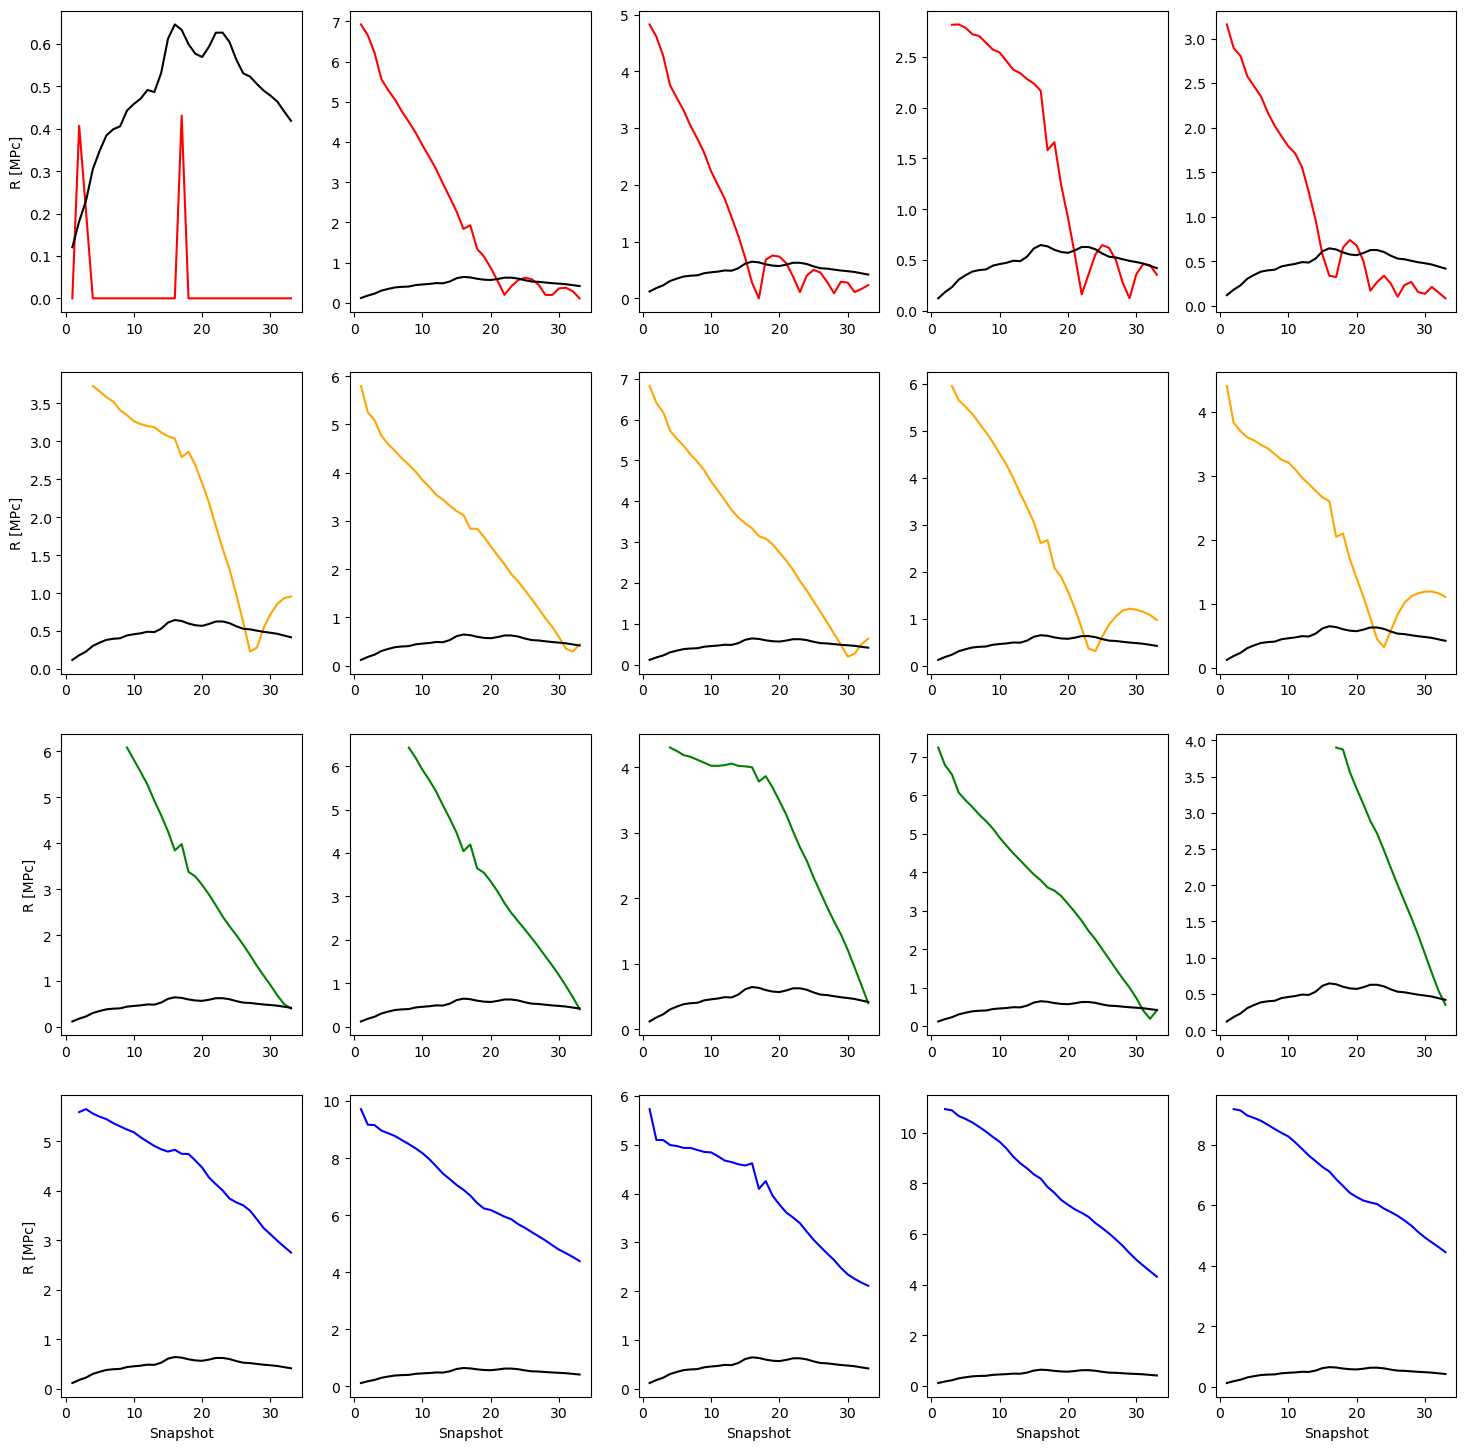

In [86]:
firstfofid = 'galID:' + str(halo_properties['haloID:0']['galaxies']['FirstSubhaloInFOFGroupID'])

fig,ax = plt.subplots(4,5, figsize = (18,18))

for i, ind in enumerate(np.random.choice(cl_ind, 5)):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[cl_ind[i]]
    
    ax[0,i].plot(np.array(halo_properties['haloID:0']['galaxies'][galid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'red')
    ax[0,i].plot(np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(bs_ind, 5)):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[bs_ind[i]]
    
    ax[1,i].plot(np.array(halo_properties['haloID:0']['galaxies'][galid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'orange')
    ax[1,i].plot(np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(rin_ind, 5)):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[rin_ind[i]]
    
    ax[2,i].plot(np.array(halo_properties['haloID:0']['galaxies'][galid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'green')
    ax[2,i].plot(np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

for i, ind in enumerate(np.random.choice(ot_ind, 5)):
    galid = list(halo_properties['haloID:0']['galaxies'].keys())[ot_ind[i]]
    
    ax[3,i].plot(np.array(halo_properties['haloID:0']['galaxies'][galid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][galid]['dist']), c = 'blue')
    ax[3,i].plot(np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['snap']), np.array(halo_properties['haloID:0']['galaxies'][firstfofid]['groupR200']), c = 'black')

    
ax[3,0].set_xlabel('Snapshot')
ax[3,1].set_xlabel('Snapshot')
ax[3,2].set_xlabel('Snapshot')
ax[3,3].set_xlabel('Snapshot')
ax[3,4].set_xlabel('Snapshot')

ax[0,0].set_ylabel('R [MPc]')
ax[1,0].set_ylabel('R [MPc]')
ax[2,0].set_ylabel('R [MPc]')
ax[3,0].set_ylabel('R [MPc]')